In [3]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
#from cd_rom_public import cd_rom
from interpolators import TorchLinearInterpolator
from QuickAndDirty.nnde_adjoint import nddesolve_adjoint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'QuickAndDirty'

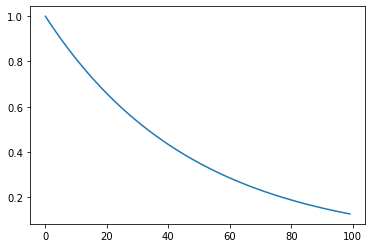

In [8]:

plt.plot(np.logspace(1,1e-1,100)/10)

torch.Size([10001, 1])


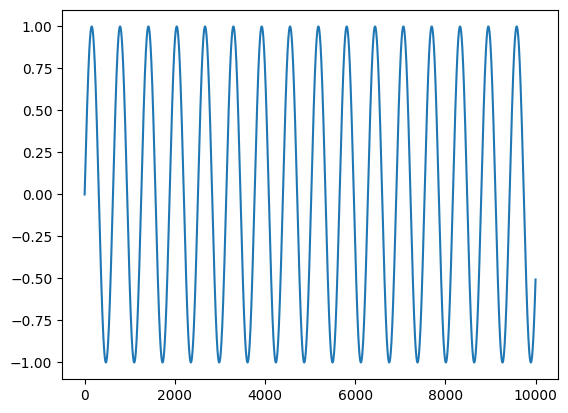

In [81]:
tmax = 100
dt = 1e-2
ts = np.linspace(0, tmax, int(tmax / dt) + 1)
np_data = np.sin(ts)  # +np.sin(1.27*time)
ys = torch.tensor(np_data).reshape(-1, 1)
print(ys.shape)
plt.plot(np_data)

In [82]:
class NDDE(nn.Module):
    def __init__(self, dim, list_delays, width=64):
        super().__init__()
        self.in_dim = dim * (1 + len(list_delays))
        self.delays = list_delays
        self.model = nn.Sequential(
            nn.Linear(self.in_dim, width),
            nn.Tanh(),
            nn.Linear(width, width),
            nn.Tanh(),
            nn.Linear(width, dim),
        )

    def forward(self, t, z, *, history):
        inp = torch.cat([z, *history], dim=-1)
        return self.model(inp)

In [83]:
def get_batch(
    ts,
    ys,
    list_delays,
    batch_size=256,
    length=100,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    """
    ts : [N_t]
    ys : [N_t, #features]
    """
    dt = ts[1] - ts[0]
    max_delay = max(list_delays)
    max_delay_idx = int(max_delay / dt)
    # pick random indices for each batch
    rand_idx = np.random.choice(
        ys.shape[0] - max_delay_idx - length - 1, size=batch_size
    )
    # history_batch : [batch_size, max_delay_idx, #features]
    # ts_history : [length] negative time
    # data_batch : [batch_size, length, #features]
    history_batch = torch.stack([ys[i : i + max_delay_idx + 1] for i in rand_idx])
    ts_history = torch.linspace(-max_delay, 0, max_delay_idx + 1)
    data_batch = torch.stack(
        [ys[i + max_delay_idx : i + max_delay_idx + length + 1] for i in rand_idx]
    )
    ts_data = torch.linspace(0, length * dt, length + 1)
    interpolator = TorchLinearInterpolator(ts_history, history_batch, device)

    return interpolator, ts_data, data_batch

In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ts, ys = torch.Tensor(ts), torch.Tensor(ys)
ts, ys = ts.to(device), ys.to(device)
interpolator, ts_data, data_batch = get_batch(ts, ys, [1.0, 2.0])

([<matplotlib.lines.Line2D at 0x7fdef790c760>],
 torch.Size([10001, 1]),
 torch.Size([]))

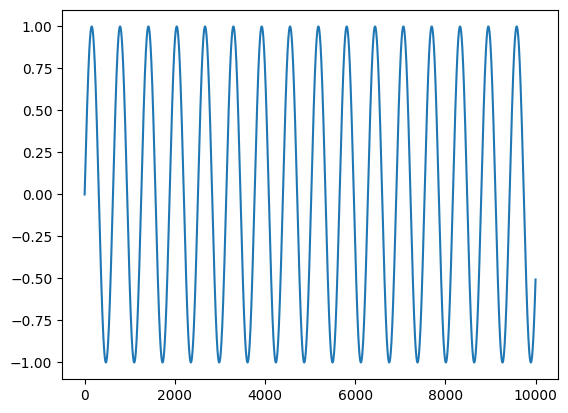

In [85]:
plt.plot(ys.cpu()), ys.shape, ys[0, 0].shape

In [86]:
length = 200
integration_options = {
    "nSteps": length - 1,
    "dt": dt,
    "t0": 0,
    "eval_idx": np.arange(length),
}
delay_pts = [int((2 * np.pi / 4) / dt)]
list_delays = [d * dt for d in delay_pts]
model = NDDE(1, list_delays, width=64).to(ys.dtype).cuda()
lossfunc = nn.MSELoss()
opt = torch.optim.SGD(model.parameters(), lr=1e-6, weight_decay=1e-4)
losses = []
lens = []

In [87]:
interpolator, ts_data, data_batch = get_batch(ts, ys, list_delays, length=length)
print(ts_data.shape, data_batch.shape, interpolator(0).shape)
model(0, data_batch[:, -1], history=[interpolator(0)]).shape

torch.Size([201]) torch.Size([256, 201, 1]) torch.Size([256, 1])


torch.Size([256, 1])

In [88]:
history, ts_data, traj = get_batch(ts, ys, list_delays, device=device, length=length)
ts_data.shape, traj.shape

(torch.Size([201]), torch.Size([256, 201, 1]))

In [89]:
ret = nddesolve_adjoint(history, model, integration_options)
ret.shape

torch.Size([200, 256, 1])

In [90]:
for i in range(100):
    opt.zero_grad()
    history, ts_data, traj = get_batch(ts, ys, list_delays, length=length)
    ret = nddesolve_adjoint(history, model, integration_options)
    # loss = torch.mean(torch.sum((ret.permute(1,0,2)-traj)**4,axis=-1)**0.25)
    loss = lossfunc(ret.permute(1, 0, 2), traj[:, 1:])
    loss.backward()
    opt.step()
    print("Epoch : {:4d}, length : {:4d}, Loss : {:.3e}".format(i, length, loss.item()))
    losses.append(loss.item())
    lens.append(length)
    if losses[-1] < 1e-2:
        length += 1
        integration_options = {
            "nSteps": length - 1,
            "dt": dt,
            "t0": 0,
            "eval_idx": np.arange(length),
        }
    if length > 1000:
        break

torch.Size([200, 256, 1])


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

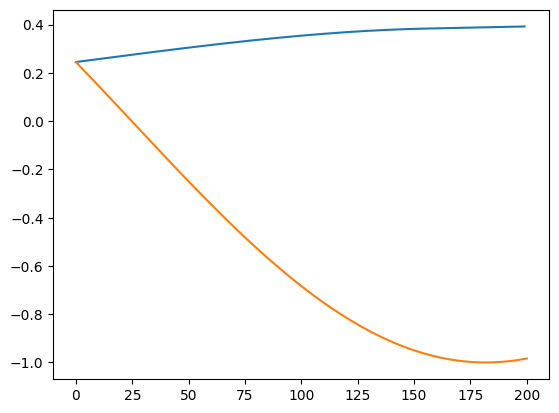

In [ ]:
plt.plot(ret[:, 0].detach().cpu().numpy())
plt.plot(traj[0, :].detach().cpu())

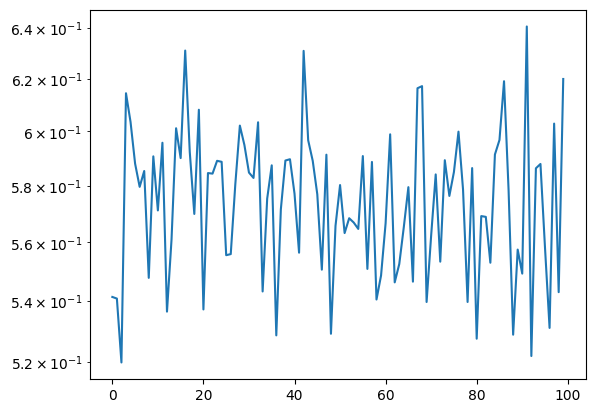

In [ ]:
plt.semilogy(losses)

In [ ]:
history, traj = get_batch(ts, ys, list_delays, device=device, length=length)
inference_options = {"nSteps": 1000, "dt": dt, "t0": 0, "eval_idx": np.arange(1000)}
ret = nddesolve_adjoint(history, model, inference_options)

ValueError: too many values to unpack (expected 2)

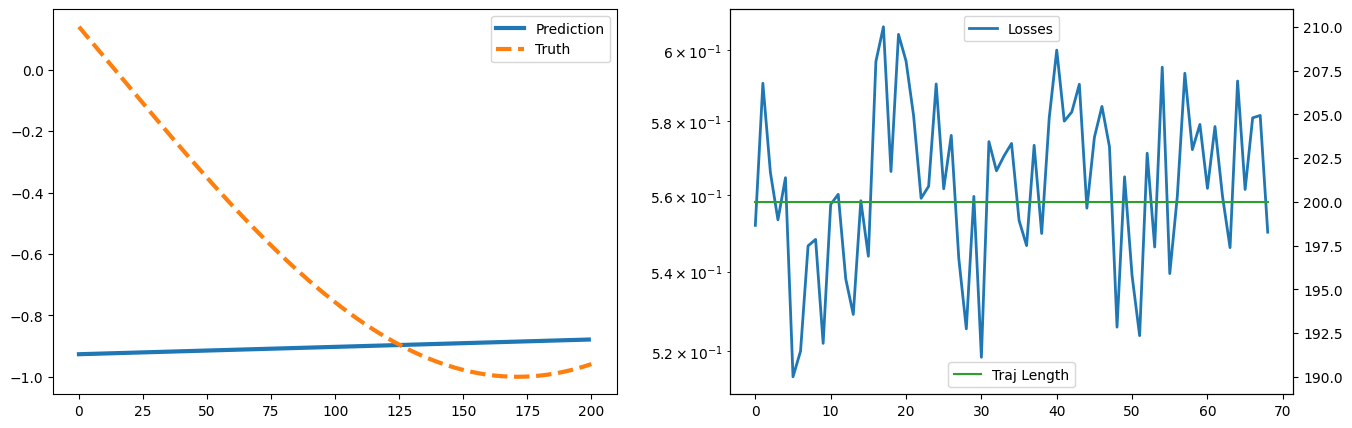

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))
plt.sca(axs[0])
plt.plot(ret[:, 0].detach().cpu().numpy(), label="Prediction", lw=3)
plt.plot(traj[0, :].detach().cpu(), "--", label="Truth", lw=3)
plt.legend()
plt.sca(axs[1])
plt.semilogy(losses, lw=2, label="Losses")
plt.legend(loc="upper center")
ax = axs[1].twinx()
ax.plot(lens, label="Traj Length", color="tab:green")
plt.legend(loc="lower center")

In [ ]:
%timeit ret = cd_rom.NDDE_adjoint.nddesolve_adjoint(history,model,inference_options); \
        loss = torch.linalg.norm(ret); loss.backward()

In [ ]:
history, traj = get_batch(delay_pts, 75)

In [ ]:
interpolator = cd_rom.interpolators.TorchLinearInterpolator(
    traj.permute(1, 0, 2), time=dt * torch.arange(traj.shape[1]).cuda()
)

In [ ]:
traj.shape

In [ ]:
spl_time = np.linspace(0, (traj.shape[1] - 1) * dt, 1000)
c = np.random.choice(traj.shape[0])
interpolated = []
for t in spl_time:
    interpolated.append(interpolator(t))
interpolated = torch.stack(interpolated)
plt.plot(spl_time, interpolated[:, c].detach().cpu())
plt.plot(dt * np.arange(traj.shape[1]), traj[c, :].detach().cpu(), "--")